##RAM++运行过程

In [ ]:
# 导入必要的库
import numpy as np
import random, os, time
import torch
from PIL import Image
from ram.models import ram_plus
from ram import inference_ram as inference
from ram import get_transform

# 设置预训练模型路径和图像尺寸
pretrained_model_path = 'ram_plus_swin_large_14m.pth'  # 你需要上传这个文件到 Colab 或者使用在线路径
image_size = 384

# 设置设备为GPU（Colab 默认提供 GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 获取图像预处理函数
transform = get_transform(image_size=image_size)

# 加载模型，设置为评估模式，并将其移动到指定设备
model = ram_plus(pretrained=pretrained_model_path,
                 image_size=image_size,
                 threshold=0.8,
                 vit='swin_l')
model.eval()
model = model.to(device)

# 上传图片到 Colab
from google.colab import files
uploaded = files.upload()

# 获取所有上传的图片文件路径
root = './'  # 上传的文件默认在当前工作目录
prex = '.jpg'
flist = [os.path.join(root, x) for x in os.listdir(root) if prex in x]

# 遍历文件列表，进行推理
for path in flist:
    # 读取并预处理图像，然后移动到指定设备
    image = transform(Image.open(path)).unsqueeze(0).to(device)

    # 记录时间并进行推理
    t0 = time.time()
    res = inference(image, model)
    rt = time.time() - t0

    # 打印运行时间和推理结果
    print(f"运行时间：{rt:.4f}, 图片路径：{path}")
    print("Image Tags: ", res[0])
    print("图像标签: ", res[1])

# Combining Grounding DINO with Segment Anything (SAM) for text-based mask generation

In this notebook, we're going to combine 2 very cool models - [Grounding DINO](https://huggingface.co/docs/transformers/main/en/model_doc/grounding-dino) and [SAM](https://huggingface.co/docs/transformers/en/model_doc/sam). We'll use Grounding DINO to generate bounding boxes based on text prompts, after which we can prompt SAM to generate corresponding segmentation masks for them.

This is based on the popular [Grounded Segment Anything](https://github.com/IDEA-Research/Grounded-Segment-Anything) project - just with fewer lines of code as the models are now available in the Transformers library. Refer to the [paper](https://arxiv.org/abs/2401.14159) for details.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/grounded_sam.png"
alt="drawing" width="900"/>

<small> Grounded SAM overview. Taken from the <a href="https://github.com/IDEA-Research/Grounded-Segment-Anything">original repository</a>. </small>

Author of this notebook: [Eduardo Pacheco](https://huggingface.co/EduardoPacheco) - give him a follow on Hugging
 Face!

## Set-up environment

Let's start by installing 🤗 Transformers from source since Grounding DINO is brand new at the time of writing.

Grounding DINO已经在写这个文档的时候更新了，因此我们先从来源处下载Transformers作为开始。

In [1]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

Let's start by importing the required libraries.

导入需要的第三方库。

In [2]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

## Result Utils

We'll store the detection results of Grounding DINO in a dedicated Python dataclass.

我们在一个专用的Python数据类中存储Grounding DINO的检测结果。

In [5]:
from dataclasses import dataclass
from typing import List, Optional, Dict
import numpy as np

@dataclass # 使用 @dataclass 装饰器定义一个名为 BoundingBox 的数据类
class BoundingBox:
    # 定义四个整数类型的字段，分别表示边界框的左上角和右下角的坐标
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    # 定义一个名为 xyxy 的属性方法，返回一个包含边界框坐标的列表
    @property
    def xyxy(self) -> List[float]:
        # 返回一个包含 xmin, ymin, xmax, ymax 的列表，类型为 float
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass # 使用 @dataclass 装饰器定义一个名为 DetectionResult 的数据类
class DetectionResult:
    # 定义三个字段：score（浮点数），label（字符串），box（BoundingBox 对象）
    score: float
    label: str
    box: BoundingBox
    # 定义一个可选字段 mask，默认值为 None
    mask: Optional[np.array] = None

    # 定义一个类方法 from_dict，用于从字典创建 DetectionResult 实例
    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        # 从字典中提取 score 和 label
        score = detection_dict['score']
        label = detection_dict['label']
        # 从字典中提取 box 信息，并创建 BoundingBox 实例
        box = BoundingBox(
            xmin=detection_dict['box']['xmin'],
            ymin=detection_dict['box']['ymin'],
            xmax=detection_dict['box']['xmax'],
            ymax=detection_dict['box']['ymax']
        )
        # 返回一个新的 DetectionResult 实例
        return cls(score=score, label=label, box=box)

## Plot Utils

Below, some utility functions are defined as we'll draw the detection results of Grounding DINO on top of the image.

定义一些工具函数用以在图像的顶部写下Grounding DINO的检测结果。

In [6]:
from typing import Union, List, Optional, Dict
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 定义一个函数 annotate，用于在图像上标注检测结果
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # 如果输入图像是 PIL Image 类型，将其转换为 OpenCV 格式（numpy 数组）
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    # 将图像从 RGB 格式转换为 BGR 格式（OpenCV 默认格式）
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # 遍历所有的检测结果，并在图像上添加边界框和掩码
    for detection in detection_results:
        label = detection.label  # 获取检测结果的标签
        score = detection.score  # 获取检测结果的得分
        box = detection.box  # 获取检测结果的边界框
        mask = detection.mask  # 获取检测结果的掩码（如果有）

        # 为每个检测结果随机生成一个颜色
        color = np.random.randint(0, 256, size=3)
        # 在图像上绘制边界框
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        # 在图像上添加标签和得分文本
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)
        # 如果掩码存在，则应用掩码
        if mask is not None:
            # 将掩码转换为 uint8 类型
            mask_uint8 = (mask * 255).astype(np.uint8)
            # 查找掩码的轮廓
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # 在图像上绘制掩码的轮廓
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)
    # 将图像从 BGR 格式转换回 RGB 格式，并返回
    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

# 定义一个函数 plot_detections，用于绘制标注后的图像
def plot_detections(
    image: Union[Image.Image, np.ndarray],  # 输入图像，可以是 PIL Image 或 numpy 数组
    detections: List[DetectionResult],  # 检测结果列表
    save_name: Optional[str] = None  # 保存图像的文件名（可选）
) -> None:
    annotated_image = annotate(image, detections)  # 调用 annotate 函数，获取标注后的图像
    plt.imshow(annotated_image)  # 使用 matplotlib 显示标注后的图像
    plt.axis('off')  # 关闭坐标轴
    # 如果提供了保存文件名，则保存图像
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    # 显示图像
    plt.show()

In [7]:
def random_named_css_colors(num_colors: int) -> List[str]:
    """
    返回随机选择的命名CSS颜色列表。

    参数：
    - num_colors (int): 要生成的随机颜色数量。

    返回：
    - list: 随机选择的命名CSS颜色列表。
    """
    # 命名CSS颜色列表
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # 随机抽取命名CSS颜色
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))


def plot_detections_plotly(
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    """
    使用 Plotly 绘制图像检测结果，包括边界框和检测对象的类别与得分。

    参数：
    - image: 待绘制的图像，numpy 数组格式。
    - detections: 检测结果列表，每个元素为 DetectionResult 类型。
    - class_colors: 可选参数，类别颜色字典。如果未提供，则为每个类别生成随机颜色。

    返回值：
    - None
    """

    # 如果没有提供类别颜色，则为每个类别生成随机颜色
    if class_colors is None:
        num_detections = len(detections)  # 检测结果的数量
        colors = random_named_css_colors(num_detections)  # 生成随机颜色
        class_colors = {}  # 初始化类别颜色字典
        for i in range(num_detections):  # 为每个检测结果分配颜色
            class_colors[i] = colors[i]

    # 使用 Plotly 的 px.imshow 函数显示图像
    fig = px.imshow(image)

    # 初始化形状和注释列表
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):  # 遍历每个检测结果
        label = detection.label  # 检测到的类别标签
        box = detection.box  # 边界框坐标
        score = detection.score  # 检测得分
        mask = detection.mask  # 检测掩码

        # 将掩码转换为多边形
        polygon = mask_to_polygon(mask)

        # 添加多边形轨迹到图像
        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],  # 多边形的 x 坐标
            y=[point[1] for point in polygon] + [polygon[0][1]],  # 多边形的 y 坐标
            mode='lines',  # 绘制模式为线条
            line=dict(color=class_colors[idx], width=2),  # 线条颜色和宽度
            fill='toself',  # 填充到自身
            name=f"{label}: {score:.2f}"  # 多边形名称显示标签和得分
        ))

        # 计算边界框的坐标
        xmin, ymin, xmax, ymax = box.xyxy
        # 创建边界框形状
        shape = [
            dict(
                type="rect",  # 形状类型为矩形
                xref="x", yref="y",  # 坐标参考
                x0=xmin, y0=ymin,  # 矩形左下角坐标
                x1=xmax, y1=ymax,  # 矩形右上角坐标
                line=dict(color=class_colors[idx])  # 矩形线条颜色
            )
        ]
        # 创建注释
        annotation = [
            dict(
                x=(xmin+xmax) // 2, y=(ymin+ymax) // 2,  # 注释位置为矩形中心
                xref="x", yref="y",  # 坐标参考
                text=f"{label}: {score:.2f}",  # 注释文本显示标签和得分
            )
        ]

        # 将形状和注释添加到列表
        shapes.append(shape)
        annotations.append(annotation)

    # 更新布局
    button_shapes = [dict(label="None",method="relayout",args=["shapes", []])]  # 创建一个按钮用于清除所有形状
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}",method="relayout",args=["shapes", shape]) for idx, shape in enumerate(shapes)  # 为每个检测创建一个按钮
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]  # 创建一个按钮用于显示所有形状

    fig.update_layout(
        xaxis=dict(visible=False),  # 隐藏 x 轴
        yaxis=dict(visible=False),  # 隐藏 y 轴
        showlegend=True,  # 显示图例
        updatemenus=[  # 更新菜单
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(  # 图例设置
            orientation="h",  # 水平方向
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # 显示绘制的图像
    fig.show()

## Utils

In [8]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    """
    将二值掩码转换为多边形顶点列表。

    参数：
    - mask: 二值掩码，numpy 数组格式。

    返回值：
    - List[List[int]]: 多边形顶点列表，每个顶点为 [x, y] 格式。
    """
    # 在二值掩码中寻找轮廓
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 寻找面积最大的轮廓
    largest_contour = max(contours, key=cv2.contourArea)

    # 提取轮廓的顶点
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    将多边形转换为分割掩码。

    参数：
    - polygon: 多边形顶点列表，每个顶点为 (x, y) 格式。
    - image_shape: 掩码的图像形状，(height, width) 格式。

    返回值：
    - np.ndarray: 填充了多边形的分割掩码。
    """
    # 创建一个空掩码
    mask = np.zeros(image_shape, dtype=np.uint8)

    # 将多边形顶点转换为数组
    pts = np.array(polygon, dtype=np.int32)

    # 用白色 (255) 填充多边形
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    """
    加载图像。

    参数：
    - image_str: 图像的路径或URL。

    返回值：
    - Image.Image: 加载的图像。
    """
    if image_str.startswith("http"):  # 如果是URL，则通过HTTP请求获取图像
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:  # 否则直接从文件路径加载图像
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    """
    从检测结果中提取边界框。

    参数：
    - results: 检测结果。

    返回值：
    - List[List[List[float]]]: 边界框列表，每个边界框为 [x1, y1, x2, y2] 格式。
    """
    boxes = []
    for result in results:  # 遍历每个检测结果
        xyxy = result.box.xyxy  # 提取边界框坐标
        boxes.append(xyxy)

    return [boxes]  # 返回边界框列表

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    """
    对掩码进行优化处理，可选择是否进行多边形细化。

    参数：
    - masks: 原始掩码，torch.BoolTensor 格式。
    - polygon_refinement: 是否进行多边形细化，默认为 False。

    返回值：
    - List[np.ndarray]: 优化后的掩码列表。
    """
    masks = masks.cpu().float()  # 将掩码转移到CPU并转换为浮点数
    masks = masks.permute(0, 2, 3, 1)  # 调整掩码的维度顺序
    masks = masks.mean(axis=-1)  # 在最后一个维度上取平均值
    masks = (masks > 0).int()  # 二值化处理
    masks = masks.numpy().astype(np.uint8)  # 转换为numpy数组并指定数据类型
    masks = list(masks)  # 将掩码转换为列表

    if polygon_refinement:  # 如果需要进行多边形细化
        for idx, mask in enumerate(masks):  # 遍历每个掩码
            shape = mask.shape  # 获取掩码的形状
            polygon = mask_to_polygon(mask)  # 将掩码转换为多边形
            mask = polygon_to_mask(polygon, shape)  # 将多边形转换回掩码
            masks[idx] = mask  # 更新掩码列表

    return masks  # 返回优化后的掩码列表

## Grounded Segment Anything (SAM)

Now it's time to define the Grounded SAM approach!

The approach is very simple:
1. use Grounding DINO to detect a given set of texts in the image. The output is a set of bounding boxes.
2. prompt Segment Anything (SAM) with the bounding boxes, for which the model will output segmentation masks.

现在是时候定义Grounded SAM 方法了！

这个方法非常简单：

1、用Grounding DINO去检测已给出一套文本的图片，输出是一套的边界框。

2、根据边界框调用Segment Anything（SAM），模型输出切割掩码。

In [9]:
def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    使用 Grounding DINO 以零样本的方式在图像中检测一组标签。

    参数：
    - image: 待检测的图像，PIL Image 对象。
    - labels: 需要检测的标签列表。
    - threshold: 检测阈值，默认为 0.3。
    - detector_id: 检测模型的标识符，如果未指定，则使用默认模型。

    返回值：
    - List[Dict[str, Any]]: 检测结果列表，每个结果为一个字典。
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"  # 判断是否有可用的CUDA设备
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"  # 如果未指定detector_id，则使用默认模型
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)  # 初始化检测管道

    # 确保所有标签以点号结尾
    labels = [label if label.endswith(".") else label+"." for label in labels]

    # 使用检测管道进行检测
    results = object_detector(image, candidate_labels=labels, threshold=threshold)
    # 将检测结果转换为 DetectionResult 对象列表
    results = [DetectionResult.from_dict(result) for result in results]

    return results  # 返回检测结果列表

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    使用 Segment Anything (SAM) 模型根据图像和一组边界框生成掩码。

    参数：
    - image: 待分割的图像，PIL Image 对象。
    - detection_results: 检测结果列表。
    - polygon_refinement: 是否进行多边形细化，默认为 False。
    - segmenter_id: 分割模型的标识符，如果未指定，则使用默认模型。

    返回值：
    - List[DetectionResult]: 分割结果列表，每个结果包含掩码信息。
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"  # 判断是否有可用的CUDA设备
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"  # 如果未指定segmenter_id，则使用默认模型

    # 初始化分割模型和处理器
    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    # 从检测结果中提取边界框
    boxes = get_boxes(detection_results)
    # 将图像和边界框输入处理器，获取模型输入
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    # 运行分割模型
    outputs = segmentator(**inputs)
    # 后处理分割结果，获取掩码
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    # 对掩码进行细化处理
    masks = refine_masks(masks, polygon_refinement)

    # 将掩码信息添加到检测结果中
    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results  # 返回包含掩码信息的检测结果列表

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    """
    执行基于标签的图像分割。

    参数：
    - image: 待分割的图像，可以是 PIL Image 对象或图像路径。
    - labels: 需要检测的标签列表。
    - threshold: 检测阈值，默认为 0.3。
    - polygon_refinement: 是否进行多边形细化，默认为 False。
    - detector_id: 检测模型的标识符。
    - segmenter_id: 分割模型的标识符。

    返回值：
    - Tuple[np.ndarray, List[DetectionResult]]: 包含原始图像和分割结果的元组。
    """
    if isinstance(image, str):  # 如果图像是路径字符串，则加载图像
        image = load_image(image)

    # 执行检测
    detections = detect(image, labels, threshold, detector_id)
    # 执行分割
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    # 返回原始图像和分割结果
    return np.array(image), detections

### Inference

Let's showcase Grounded SAM on our favorite image: the cats image from the COCO dataset.

在COCO数据集的猫的图片上展示Grounded SAM

In [13]:
# 定义图像的URL地址
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# 定义需要检测的标签列表，这里检测“一只猫”和“一个遥控器”
labels = ["a cat.", "a remote control."]
# 设置检测阈值，即检测结果的置信度门限
threshold = 0.3

# 指定检测模型的标识符，这里使用IDEA-Research提供的Grounding DINO tiny模型
detector_id = "IDEA-Research/grounding-dino-tiny"
# 指定分割模型的标识符，这里使用facebook提供的SAM-vit-base模型
segmenter_id = "facebook/sam-vit-base"

In [14]:
# 调用 grounded_segmentation 函数执行基于标签的图像分割
# 该函数将下载图像、检测标签中的对象，并生成对应的分割掩码
image_array, detections = grounded_segmentation(
    # 指定待分割的图像URL
    image=image_url,
    # 指定需要检测的标签列表
    labels=labels,
    # 设置检测阈值，即检测结果的置信度门限
    threshold=threshold,
    # 设置是否进行多边形细化，True表示进行细化，可以提高掩码质量
    polygon_refinement=True,
    # 指定检测模型的标识符，这里使用IDEA-Research提供的Grounding DINO tiny模型
    detector_id=detector_id,
    # 指定分割模型的标识符，这里使用facebook提供的SAM-vit-base模型
    segmenter_id=segmenter_id
)

Device set to use cuda


Let's visualize the results:

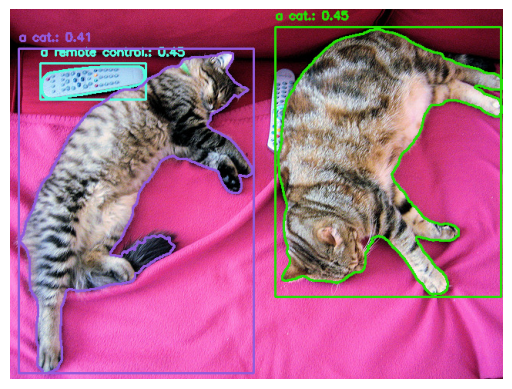

In [15]:
# 调用 plot_detections 函数来绘制检测结果
# 该函数将在图像上绘制边界框、多边形掩码，并保存到指定的文件中

# 函数参数解释：
# image_array: 待绘制的图像，numpy 数组格式。
# detections: 检测结果列表，包含每个检测对象的详细信息。
# "cute_cats.png": 绘制结果的保存文件名。

plot_detections(
    # 提供待绘制的图像数组，这是由之前的 grounded_segmentation 函数返回的
    image_array,
    # 提供检测结果列表，这也是由之前的 grounded_segmentation 函数返回的
    detections,
    # 指定绘制结果的保存文件名
    "cute_cats.png"
)

In [16]:
# 调用 plot_detections_plotly 函数来使用 Plotly 绘制检测结果
# 该函数将在图像上绘制边界框和多边形掩码，并展示一个交互式的图表

plot_detections_plotly(
    # 提供待绘制的图像数组，这是由之前的 grounded_segmentation 函数返回的
    image_array,
    # 提供检测结果列表，这也是由之前的 grounded_segmentation 函数返回的
    detections
)